# Ensamble based inversion

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import linalg
import time
sns.set_style("white")
np.random.seed(0)

In [2]:
t = np.loadtxt("https://folk.ntnu.no/joeid/emnemodul/traveltimedata.txt")
data = pd.DataFrame({'receiver_layer': np.linspace(51,100,50), 
                     'travel_time': t})

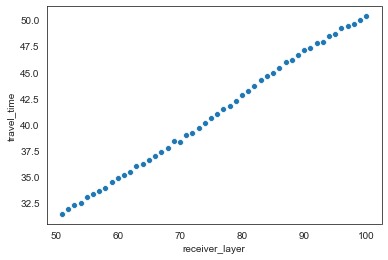

In [3]:
nyc_chart = sns.scatterplot(x = "receiver_layer",
                         y = "travel_time",
                         data=data)

# a)

In [16]:
def create_ensemble(B, n):
    mu = 0.5-0.001*np.linspace(1,n,num = n)
    covar = np.identity(n)*0.05**2
    eta = 0.1
    for i in range(n-1):
        for j in range(i+1,n):
            h = abs(i-j)
            covar[i,j] = covar[j,i] = 0.05**2*(1+eta*h)*np.exp(-eta*h)
    return(mu,covar)

def r_x(mu,covar,B,n):
    x = np.zeros((B,n))
    L = linalg.cholesky(covar)
    for i in range(B):
        x[i,:] = mu + L.transpose()@np.random.normal(0, 1, n)
    return(x)


def forecast_ensemble(t, B, n, direction):
    np.random.seed(44)
    mu, covar = create_ensemble(B,n)
    x = r_x(mu, covar, B, n)
    theta = np.cos(np.arctan(40/np.linspace(51,n,50)))
    t_for = np.zeros(B)
    x_asim = np.zeros((B,n,3))
    count = 0
    tau = 0.1
    if direction == 1:
        iteration = range(50)
    elif direction == -1:
        iteration = range(49,-1,-1)
    for j in iteration:
        sigma = np.zeros(n)
        K = np.zeros(n)
        for b in range(B):
            t_for[b] = sum(x[b,0:(j+51)])/theta[j] + np.random.normal(0,tau**2)
        mu_t = t_for.mean()
        var_t = sum((t_for - mu_t)**2)/B
        for i in range(n):
            mu_x = x[:,i].mean()
            for b in range(B):
                sigma[i] += (t_for[b] - mu_t)*(x[b,i] - mu_x)/B
        K= sigma/var_t
        for b in range(B):
            x[b,:] = x[b,:] + K*(t[j] - t_for[b])
        if (j == 0) or (j == 24) or (j==49):
            x_asim[:,:,count] = x
            count += 1
    return(x_asim) 
  
    
def plot_asim(x):
  plt.figure(figsize = (21,7))
  plt.subplot(131)
  plt.plot(x_asim[:,:,0].transpose())
  plt.subplot(132)
  plt.plot(x_asim[:,:,1].transpose())
  plt.subplot(133)
  plt.plot(x_asim[:,:,2].transpose())
  plt.show()

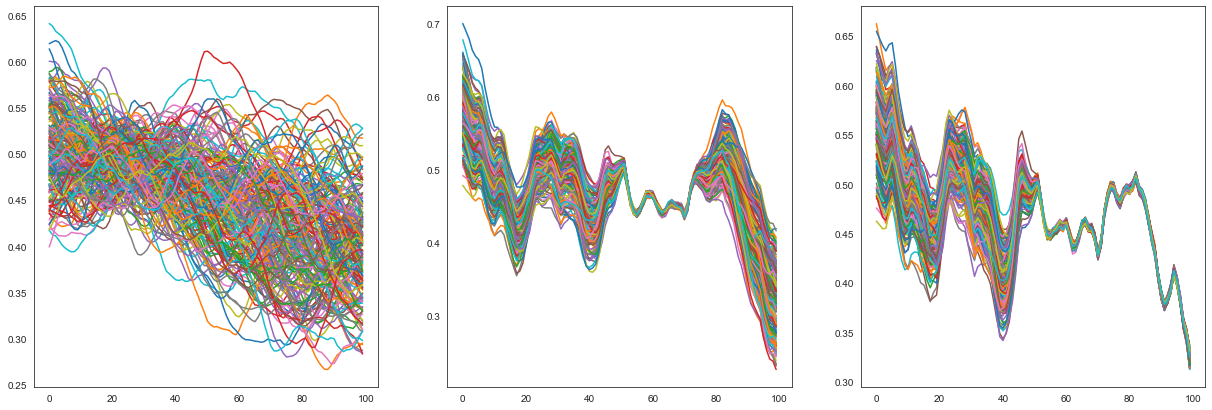

In [17]:
B = 200
n = 100
x_asim = forecast_ensemble(t,B,n,1)
plot_asim(x_asim)

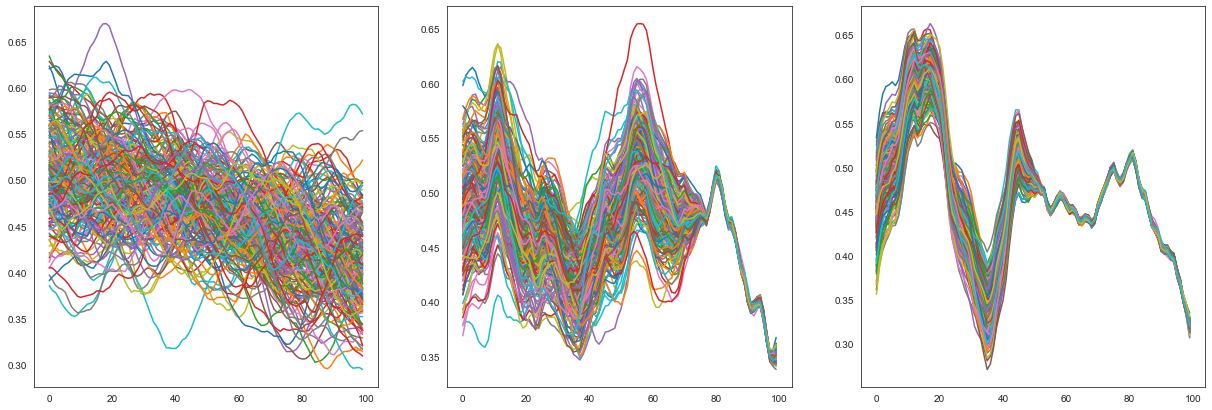

In [19]:
B = 200
x_asim = forecast_ensemble(t,B,n,-1)
plot_asim(x_asim)

# b)

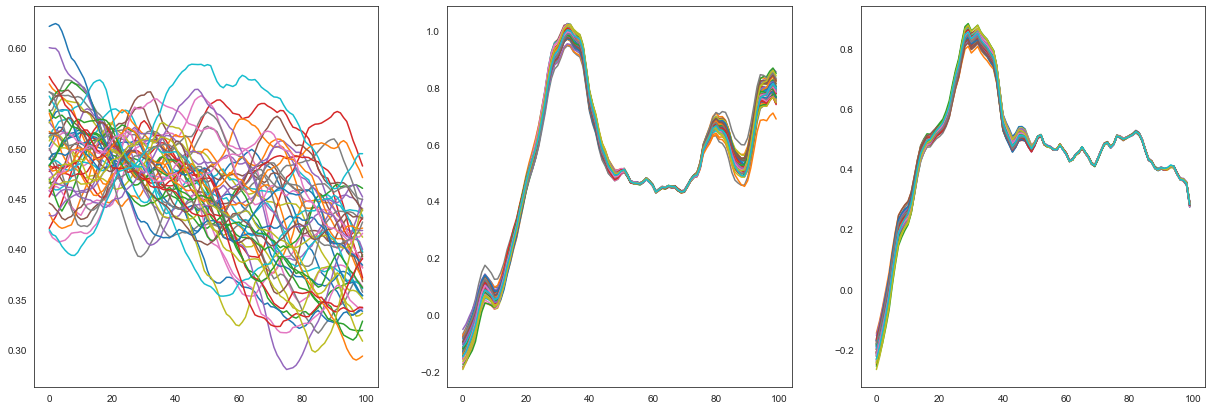

In [24]:
B = 50
x_asim = forecast_ensemble(t,B,n,1)
plot_asim(x_asim)

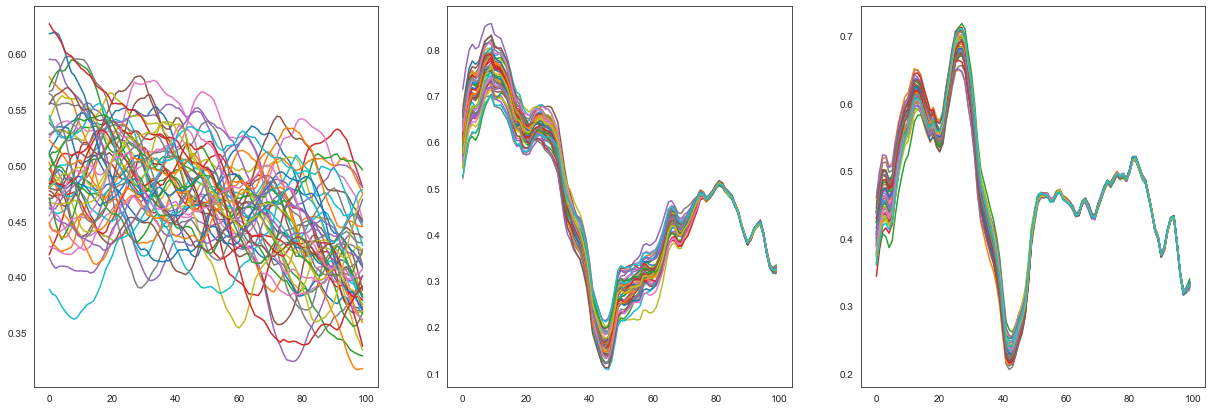

In [25]:
B = 50
x_asim = forecast_ensemble(t,B,n,-1)
plot_asim(x_asim)

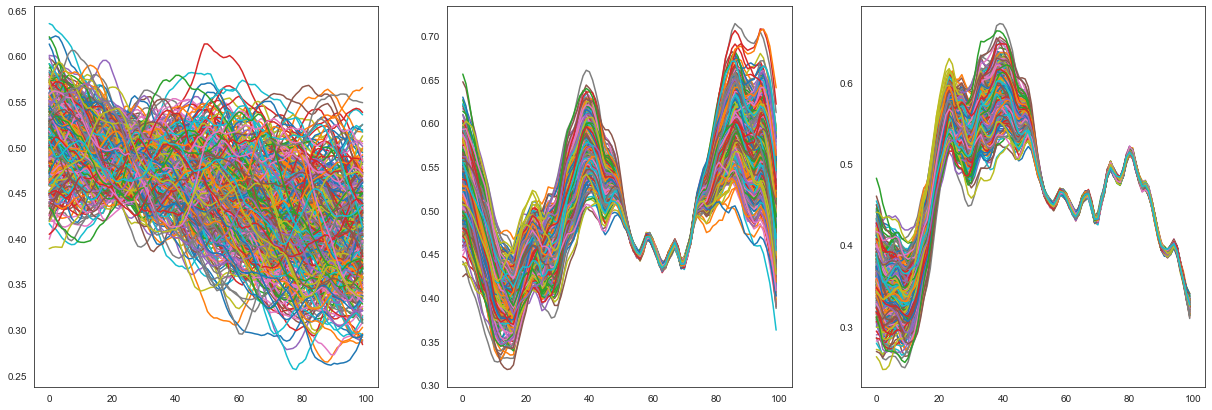

In [26]:
B = 400
x_asim = forecast_ensemble(t,B,n,1)
plot_asim(x_asim)

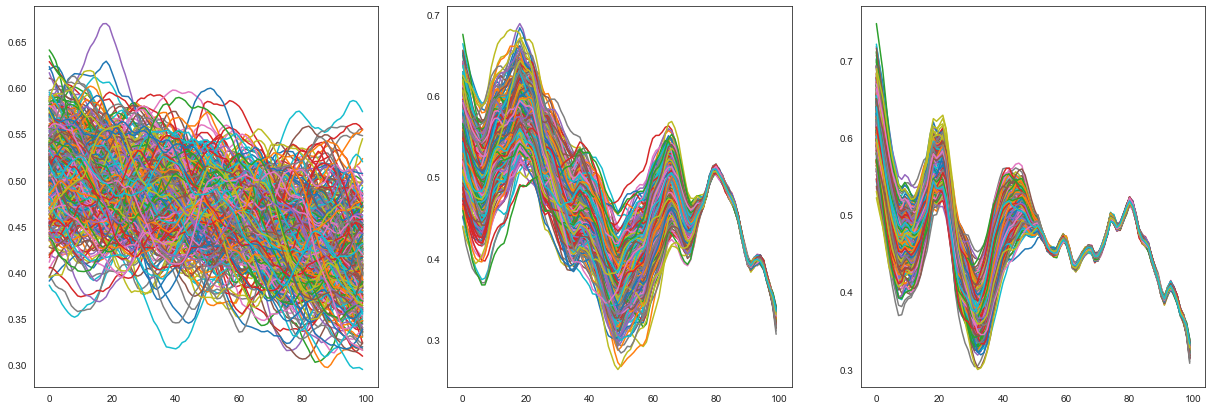

In [27]:
B = 400
x_asim = forecast_ensemble(t,B,n,-1)
plot_asim(x_asim)

# c)

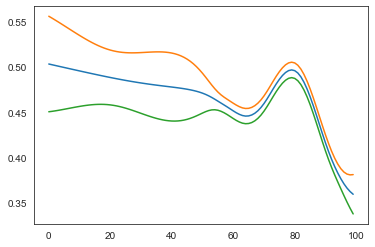

In [28]:
def kalman_filter(t, n):
    theta = np.cos(np.arctan(40/np.linspace(51,n,50)))
    sigma = 0.05
    tau = 0.1
    mu = 0.5-0.001*np.linspace(1,n,num = n)
    covar = np.identity(n)*sigma**2
    eta = 0.1
    
    for i in range(n-1):
        for j in range(i+1,n):
            h = abs(i-j)
            covar[i,j] = covar[j,i] = sigma**2*(1+eta*h)*np.exp(-eta*h)
            
    K = np.zeros(n)
    for j in range(50):
        g_j = np.concatenate((np.ones(j+51)/theta[j],np.zeros(n-j-51)))
        K = covar@np.transpose(g_j)/(g_j@covar@np.transpose(g_j)+tau**2) 
        mu = mu + K*(t[j]-g_j@mu)
        covar = covar - np.outer(K,np.matmul(g_j,covar))
        
    return(mu, covar) 

mu, covar = kalman_filter(t, n)
quantile = 1.28

lower_bound = mu-quantile*np.sqrt(covar.diagonal())
upper_bound = mu+quantile*np.sqrt(covar.diagonal())




B = 400
n = 100
x_asim = forecast_ensemble(t,B,n,1)
#plt.plot(x_asim[:,:,2].transpose())
plt.plot(mu)
plt.plot(upper_bound)
plt.plot(lower_bound)
plt.show()